In [1]:
import torch
import torch.nn.functional as F
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


8


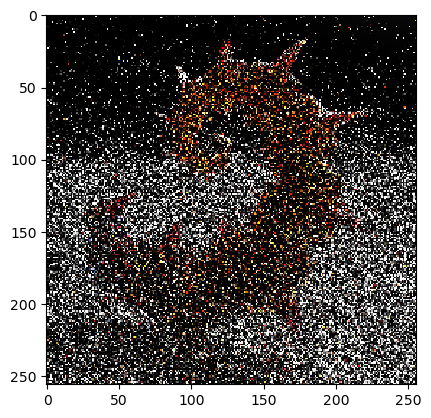

128


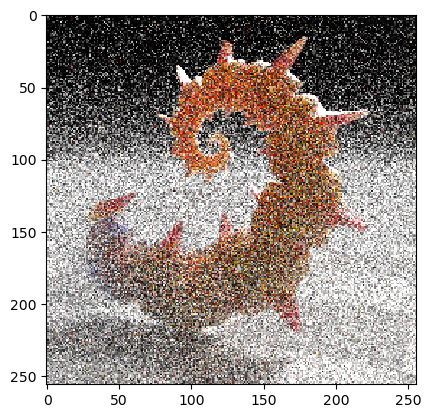

2048


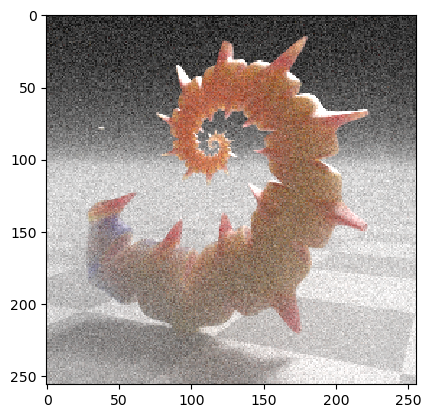

32768


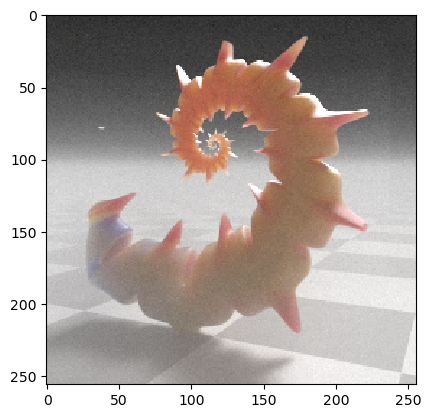

converged


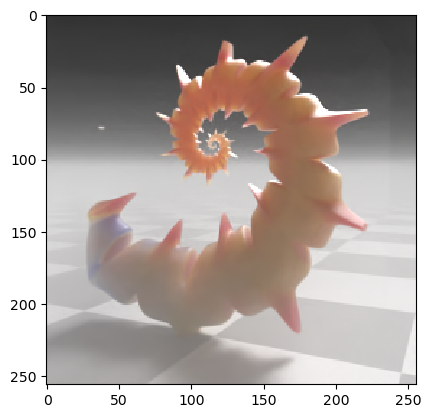

In [2]:
import oidn.wrapper
import importlib
importlib.reload(oidn.wrapper)
oidn_model = oidn.wrapper.load_model()


def load_data_file(filename, verbose=False):
    data = np.fromfile('data/'+filename, dtype=np.float32)
    n, w, h = map(int, filename[filename.find('_')+1:filename.find('.')].split('_'))
    data = data.reshape((n, 3, w, h))
    ref = np.zeros((3, w, h), dtype=np.float32)
    weights = np.zeros((3, w, h), dtype=np.float32)
    for i in range(n):
        frame = data[i]
        dw = ((frame > 0.0) & (frame < 1e4)).astype(np.float32) * 2**i
        ref += np.nan_to_num(frame, nan=0.0, posinf=0.0, neginf=0.0) * dw
        weights += dw
        if (n-i) % 4 == 1 and verbose:
            print(2**i)
            frame = np.clip(frame, 0.0, 1.0) ** (1.0/2.2)
            frame = np.einsum('kij->ijk', np.flip(frame, axis=1))
            plt.figure()
            plt.imshow(frame)
            plt.show()
    ref /= np.fmax(weights, 1)
    with torch.no_grad():
        x = ref.reshape((1, *ref.shape))
        x = np.fmax(x, 0.0) ** (1.0/2.2)
        # x = np.clip(x, 0.0, 1.0)
        x = torch.tensor(x).to(device)
        y = oidn_model(x)
        ref = np.fmax(y[0].cpu().numpy(), 0.0) ** 2.2
    if verbose:
        frame = np.clip(ref, 0.0, 1.0)
        frame = frame ** (1.0/2.2)
        frame = np.einsum('kij->ijk', np.flip(frame, axis=1))
        print("converged")
        plt.figure()
        plt.imshow(frame)
        plt.show()
    return {
        'w': w,
        'h': h,
        'data': data,
        'ref': ref
    }


_ = load_data_file("6d5a19f6_16_256_256.bin", True)

torch.Size([32, 3, 64, 64])


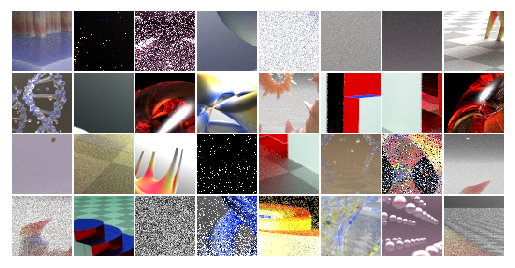

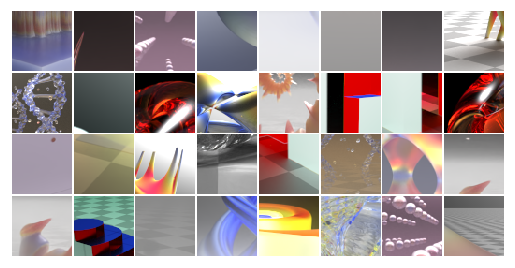

In [3]:
class RawDataset(torch.utils.data.Dataset):
    def __init__(self, n):
        import os
        self.data = [load_data_file(filename) for filename in os.listdir("data/")]
        s = 64
        self.n = n
        self.s = s
        self.coords = []
        for i in range(n):
            k = np.random.randint(0, len(self.data))
            x = np.random.randint(0, self.data[k]['w']-s)
            y = np.random.randint(0, self.data[k]['h']-s)
            self.coords.append((k, x, y))

    def __len__(self):
        return self.n

    def __getitem__(self, i):
        k, x, y = self.coords[i]
        s = self.s
        n = self.data[k]['data'].shape[0]
        total = np.zeros((3, s, s), dtype=np.float32)
        weights = np.zeros((3, s, s), dtype=np.float32)
        spp = round(0.6 * np.random.random()**4 * 2**n + 0.5)
        for _ in range(n):
            if (spp >> _) & 1 == 0:
                continue
            frame = self.data[k]['data'][_, :, x:x+s, y:y+s]
            dw = ((frame > 0.0) & (frame < 1e4)).astype(np.float32) * 2**_
            total += np.nan_to_num(frame, nan=0.0, posinf=0.0, neginf=0.0) * dw
            weights += dw
        return [
            np.fmax(total / np.fmax(weights, 1), 0.0) ** (1.0/2.2),
            np.fmax(self.data[k]['ref'][:, x:x+s, y:y+s], 0.0) ** (1.0/2.2)
        ]


def plot_imgs(x):
    plt.figure()
    x = torch.clip(x, 0.0, 1.0)
    x = torch.flip(x, [2])
    plt.imshow(np.transpose(vutils.make_grid(x[:].cpu(),
        padding=2, pad_value=1, normalize=True), (1, 2, 0)),
                interpolation='nearest')
    plt.axis("off")
    plt.show()

for x, y in torch.utils.data.DataLoader(
    RawDataset(128),
    batch_size=32,
    shuffle=True
):
    break

print(x.shape)
plot_imgs(x)
plot_imgs(y)

In [4]:
def conv3(nin, nout):
    return torch.nn.Conv2d(nin, nout, 3, padding=1, bias=True)

def relu(x):
    return F.relu(x, inplace=False)

class Model(torch.nn.Module):
    def __init__(self):
        super().__init__()
        n = 16
        self.convi = conv3(3, n)
        self.conv11 = conv3(n, n)
        self.conv12 = conv3(n, n)
        self.conv21 = conv3(n, n)
        self.conv22 = conv3(n, n)
        self.conv31 = conv3(n, n)
        self.conv32 = conv3(n, n)
        self.conv41 = conv3(n, n)
        self.conv42 = conv3(n, n)
        self.convo = conv3(n, 3)

    def forward(self, input):
        x = input
        # input
        ci = self.convi(x)
        xi = relu(ci)
        # residual 1
        c11 = self.conv11(xi)
        x = relu(c11)
        c12 = self.conv12(x)
        x1 = xi + c12
        # residual 2
        c21 = self.conv21(x1)
        x = relu(c21)
        c22 = self.conv22(x)
        x2 = x1 + c22
        # residual 3
        c31 = self.conv31(x2)
        x = relu(c31)
        c32 = self.conv32(x)
        x3 = x2 + c32
        # residual 4
        c41 = self.conv41(x3)
        x = relu(c41)
        c42 = self.conv42(x)
        x4 = x3 + c42
        # output
        co = self.convo(x4)
        return co

model = Model().to(device)
print(model)

Model(
  (convi): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv11): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv12): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv21): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv22): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv31): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv32): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv41): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv42): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (convo): Conv2d(16, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


256 0.023361509665846825
512 0.025181636214256287
768 0.022686131298542023
1024 0.02318626269698143
1280 0.024059873074293137
1536 0.01924487017095089
1792 0.01685361936688423
2048 0.015225118026137352
2304 0.015400715172290802
2560 0.011588561348617077
2816 0.015705015510320663
3072 0.010349379852414131
3328 0.013006992638111115
3584 0.021193306893110275
3840 0.011682054027915001
4096 0.01542295329272747


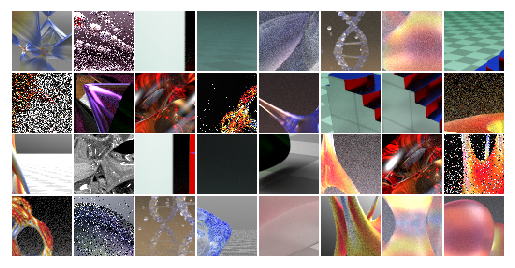

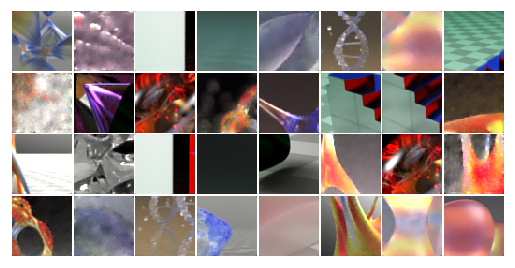

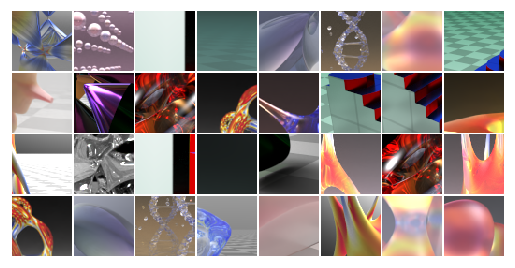

4352 0.01338560413569212
4608 0.008993175812065601
4864 0.01727128028869629
5120 0.01542874239385128
5376 0.01192607544362545
5632 0.012365832924842834
5888 0.011478953063488007
6144 0.01277353148907423
6400 0.010757080279290676
6656 0.013957567512989044
6912 0.014270639047026634
7168 0.010814009234309196
7424 0.017122332006692886
7680 0.011897451244294643
7936 0.014078490436077118
8192 0.010633746162056923


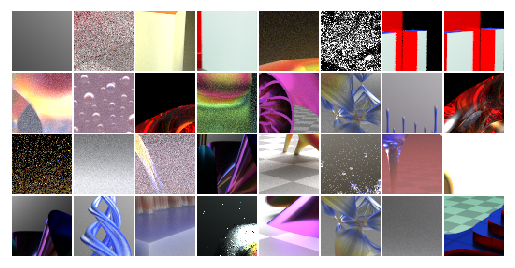

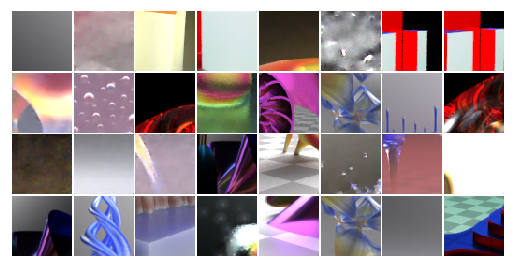

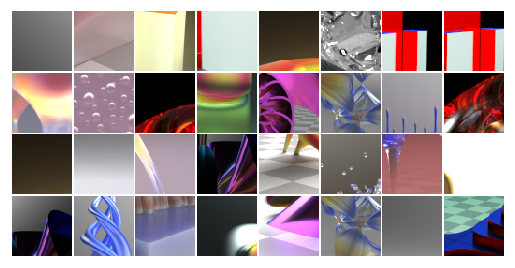

8448 0.011136002838611603
8704 0.013125201687216759
8960 0.015139974653720856
9216 0.013281969353556633
9472 0.015280695632100105
9728 0.010423845611512661
9984 0.014432182535529137
10240 0.013718418776988983
10496 0.011985091492533684
10752 0.012719882652163506
11008 0.012170610949397087
11264 0.012223487719893456
11520 0.01107603870332241
11776 0.016885800287127495
12032 0.016271105036139488
12288 0.009234726428985596


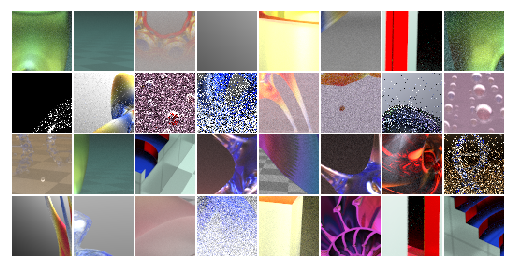

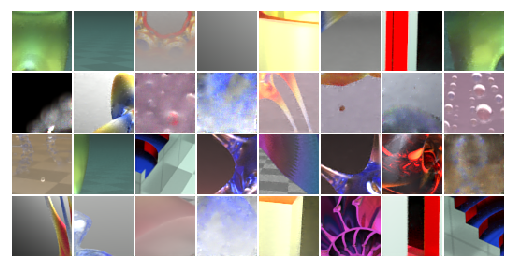

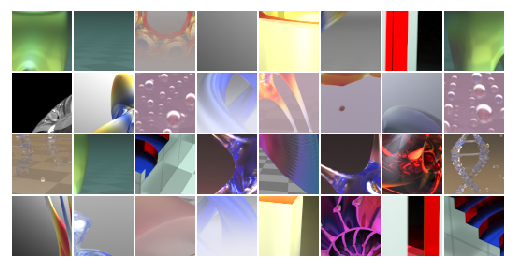

12544 0.020387452095746994
12800 0.010516447946429253
13056 0.013437081128358841
13312 0.019915781915187836
13568 0.01566610299050808
13824 0.010351104661822319
14080 0.014854103326797485
14336 0.008087025955319405
14592 0.010823866352438927
14848 0.015620902180671692
15104 0.018567532300949097
15360 0.0123196542263031
15616 0.024490319192409515
15872 0.011507444083690643
16128 0.010208288207650185
16384 0.015588724985718727


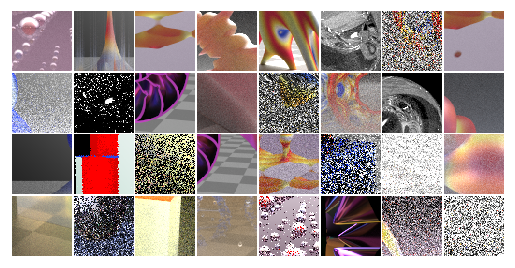

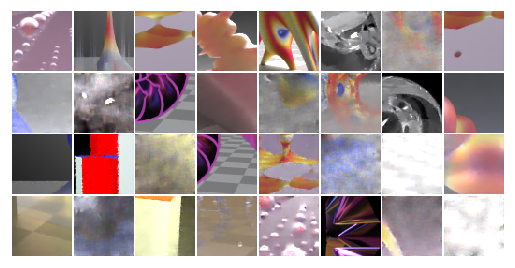

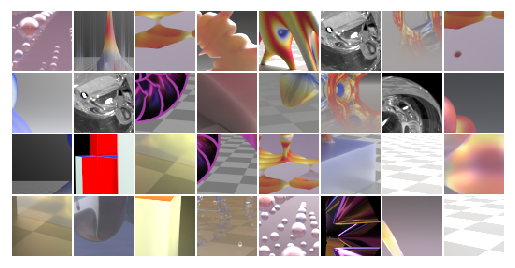

In [5]:
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=0.0005
)

def lossfun(output, reference, input):
    return torch.mean(torch.abs(output-reference))

batch_count = 0
for epoch in range(1):
    trainloader = torch.utils.data.DataLoader(
        RawDataset(2**19), batch_size=32, shuffle=True)
    for x, y in trainloader:
        x = x.to(device)
        y = y.to(device)
        x = torch.log(1+x)
        y = torch.log(1+y)
        optimizer.zero_grad()
        output = model(x)
        loss = lossfun(output, y, x)
        loss.backward()
        optimizer.step()

        batch_count += 1
        if batch_count % 256 == 0:
            print(batch_count, loss.item())
        if batch_count % 4096 == 0:
            plot_imgs(torch.exp(x)-1)
            plot_imgs(torch.exp(output.detach())-1)
            plot_imgs(torch.exp(y)-1)


In [6]:
torch.save(model, "model1.pth")

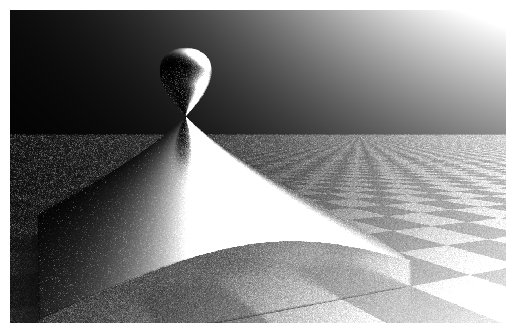

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


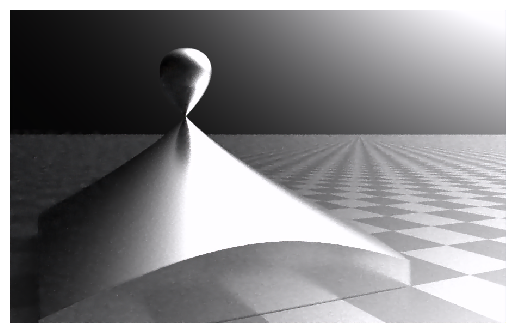

In [7]:
from PIL import Image

def load_image(filename):
    image = Image.open(filename).convert("RGB")
    image = np.array(image)
    w, h = image.shape[:2]
    image = image[:(w//16)*16, :(h//16)*16, :].astype(np.float32)/255.0
    image = torch.tensor(image, device=device).permute(2, 0, 1)
    return image


def plot_img(x):
    plt.figure()
    plt.imshow(x.permute(1, 2, 0).cpu().numpy())
    plt.axis("off")
    plt.show()


x = load_image("test/noisy00.png")
x = x.reshape(1, *x.shape)

plot_img(x[0])

with torch.no_grad():
    x = torch.log(x+1)
    y = model(x)
    y = torch.exp(y)-1

plot_img(y[0])